In [1]:
from pandas import DataFrame, read_csv
import pandas as pd
import random
import numpy as np
import json
from collections import defaultdict, Counter
import math
import sys
import itertools
import time
import scipy.stats 
from sklearn.neighbors import KernelDensity
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.optimize import curve_fit
import copy
import dill
import matplotlib.patches as mpatches
import copy
import dill

chr_lengths= {1: 643000,
                         2: 947000,
                         3: 1100000,
                         4: 1200000,
                         5: 1350000,
                         6: 1420000,
                         7: 1450000,
                         8: 1500000,
                         9: 1550000,
                         10: 1700000,
                         11: 2049999,
                         12: 2300000,
                         13: 2950000,
                         14: 3300000}

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """

    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):  #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

cpalette1 = sns.color_palette('Reds_r', 2)
cpalette2 = sns.color_palette('Blues_r', 3)
cpalette3 = sns.color_palette('Greys_r', 3)

color_map_dict = {'PC': cpalette1[0],
                 'FS': cpalette1[1],
                 'MS': cpalette1[1],
                 'GC': cpalette2[0],
                 'HS': cpalette2[1],
                  'FAV': cpalette2[2],
                  'GGC': cpalette3[0],
                  'HAV': cpalette3[1],
                  'FCS': cpalette3[2]}

In [2]:
def combine_results(pattern, metric):
    if metric != 'r_totals':
        combined_dict = defaultdict(lambda: defaultdict(list))
    else:
        combined_dict = defaultdict(list)
    for file in glob.glob(pattern):
        file_dict = json.load(open(file))
        print(file)
        for relationship in file_dict:
            if metric != 'r_totals':
                for chrom in file_dict[relationship]:
                    for segment_lengths in file_dict[relationship][chrom]:
                        combined_dict[relationship][chrom].append(segment_lengths)
            else:
                combined_dict[relationship] += file_dict[relationship]
    return combined_dict


def combine_sims(directory):
    fs_file_patterns = ['fs*_ibd_segment_numbers.json', 'fs*_ibd_segment_max.json',
               'fs*_r_totals.json']
    combined_dicts = {}
    for pattern in fs_file_patterns:
        match = re.search('fs\*_(.+).json',pattern)
        metric = match.groups()[0]
        combined_dicts[metric] = combine_results(directory + pattern, metric)
        json.dump(combined_dicts[metric], open(directory + 'fs_{m}_combined.json'.format(m=metric), 'w'), cls = NumpyEncoder)
    
    ms_file_patterns = ['ms*_ibd_segment_numbers.json', 'ms*_ibd_segment_max.json',
               'ms*_r_totals.json']

    ms_combined_dicts = {}
    for pattern in ms_file_patterns:
        match = re.search('ms\*_(.+).json',pattern)
        metric = match.groups()[0]
        ms_combined_dicts[metric] = combine_results(directory + pattern, metric)
        json.dump(ms_combined_dicts[metric], open(directory + 'ms_{m}_combined.json'.format(m=metric), 'w'), cls = NumpyEncoder)

#combine_sims('sims/f1_f2/')


In [3]:
param_dict = {}

for param_combo in ['2.0_11.3']:
    sim_types = ['fs', 'ms'] #not needed, but legacy
    raw_sim_data = defaultdict(dict)
    for sim_type in sim_types:    
        raw_sim_data[sim_type]['r_totals'] = json.load(open('../sims/f1_f2/{x}_r_totals_combined.json'.format(x=sim_type,p=param_combo)))
        raw_sim_data[sim_type]['ibd_segment_max'] = json.load(open('../sims/f1_f2/{x}_ibd_segment_max_combined.json'.format(x=sim_type,p=param_combo)))
        raw_sim_data[sim_type]['ibd_segment_numbers'] = json.load(open('../sims/f1_f2/{x}_ibd_segment_numbers_combined.json'.format(x=sim_type,p=param_combo)))
        max_segment_p_dict = defaultdict(dict)
        for relationship in raw_sim_data[sim_type]['ibd_segment_max']:
            for chrom in raw_sim_data[sim_type]['ibd_segment_max'][relationship]:
                max_segment_p_dict[relationship][chrom] = np.asarray([x for x in np.asarray(raw_sim_data[sim_type]['ibd_segment_max'][relationship][chrom]) / chr_lengths[int(chrom)]])
        raw_sim_data[sim_type]['p_ibd_max'] = max_segment_p_dict
    param_dict[param_combo] = copy.deepcopy(raw_sim_data)

for sim_type in sim_types:
    for key,value in param_dict['2.0_11.3'][sim_type].items():
        try:
            p1_p1 = value.pop('P1.P2')
        except:
            continue


In [8]:
def evaluate_max_segment_piecewise_pdf(x, relationship, chrom, pdf_dict, bandwidth =0.02):
    '''modeled as a kde with spikes'''
    #print(fs_max_segment_pdf_dict[relationship][int(chrom)])
    p0,p1,kde, tstep, = pdf_dict[relationship][int(chrom)]
                       
    if float(x) <= 0 + bandwidth:
        return p0/tstep
    elif float(x) >= 1 - bandwidth:
        return p1/tstep
    else:
        x_transmute = np.asarray([x])
        #if beta_dis:
        #    pdf = scipy.stats.beta.pdf(x, alpha, beta, loc, scale)
        #else:
        pdf = np.exp(kde.score_samples(x_transmute.reshape(-1,1)))[0]
        pdf = pdf * (1-p0-p1)
        return pdf
    
def fit_beta(relationships,):
    beta_variables = {}
    r_dict = raw_sim_data['fs']['r_totals']
    for relationship in relationships:
        print(relationship)
        r_list = r_dict[relationship]
        r_list = [x if x != 0 else 1e-9 for x in r_list]
        alpha, beta, loc, scale = scipy.stats.beta.fit(r_list, floc=0,fscale=1)
        #x = np.linspace(0, 1, 100)
        beta_variables[relationship] = (alpha, beta, loc, scale)
        
    return beta_variables


def plot_r_totals(beta_vals_dict, relationships, color_map_dict):
    x = np.linspace(0, 1, 100)
    #plt.figure(figsize = (8,5))
    i= 1
    for relationship in relationships:
        alpha, beta, loc, scale = beta_vals_dict[relationship]
        pdf = scipy.stats.beta.pdf(x, alpha, beta, loc, scale)

        plt.plot(x, pdf, color = color_map_dict[relationship], label = relationship)
        plt.xlabel('Genome-wide Total Relatedness', fontsize = 15)
        plt.ylabel('Density', fontsize = 15)
        plt.xlim(-0.05,1.05)
        plt.ylim(-0.05, 10)
        plt.legend(ncols = 3, fontsize = 12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        
def evaluate_max_segment_piecewise_pdf(x, relationship, chrom, pdf_dict, bandwidth =0.02):
    '''modeled as a kde with spikes'''
    #print(fs_max_segment_pdf_dict[relationship][int(chrom)])
    p0,p1,kde, tstep, = pdf_dict[relationship][int(chrom)]
                       
    if float(x) <= 0 + bandwidth:
        return p0/tstep
    elif float(x) >= 1 - bandwidth:
        return p1/tstep
    else:
        x_transmute = np.asarray([x])
        #if beta_dis:
        #    pdf = scipy.stats.beta.pdf(x, alpha, beta, loc, scale)
        #else:
        pdf = np.exp(kde.score_samples(x_transmute.reshape(-1,1)))[0]
        pdf = pdf * (1-p0-p1)
        return pdf
    
def fit_beta(relationships,):
    beta_variables = {}
    r_dict = raw_sim_data['fs']['r_totals']
    for relationship in relationships:
        print(relationship)
        r_list = r_dict[relationship]
        r_list = [x if x != 0 else 1e-9 for x in r_list]
        alpha, beta, loc, scale = scipy.stats.beta.fit(r_list, floc=0,fscale=1)
        #x = np.linspace(0, 1, 100)
        beta_variables[relationship] = (alpha, beta, loc, scale)
        
    return beta_variables


def plot_r_totals(beta_vals_dict, relationships, color_map_dict):
    x = np.linspace(0, 1, 100)
    #plt.figure(figsize = (8,5))
    i= 1
    for relationship in relationships:
        alpha, beta, loc, scale = beta_vals_dict[relationship]
        pdf = scipy.stats.beta.pdf(x, alpha, beta, loc, scale)

        plt.plot(x, pdf, color = color_map_dict[relationship], label = relationship)
        plt.xlabel('Genome-wide Total Relatedness', fontsize = 15)
        plt.ylabel('Density', fontsize = 15)
        plt.xlim(-0.05,1.05)
        plt.ylim(-0.05, 10)
        plt.legend(ncols = 3, fontsize = 12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        

def create_pdfs(p_max_segment_dict, bandwidth= 0.05):
    max_segment_pdf_dict = defaultdict(dict)
    for relationship in p_max_segment_dict:
        for chromosome in p_max_segment_dict[relationship]:
            data = np.asarray(p_max_segment_dict[relationship][chromosome])
            mask0 = np.asarray(p_max_segment_dict[relationship][chromosome]) <= 0 + bandwidth
            mask1 = np.asarray(p_max_segment_dict[relationship][chromosome]) >= 1 - bandwidth
            mask = ~mask0 & ~mask1
            data = np.asarray(data[mask])

            p0 = (np.sum(mask0) + 1 )/ (len(mask0) + 3)
            p1 = (np.sum(mask1) + 1 )/ (len(mask1) + 3)
            kde = KernelDensity(kernel='gaussian',bandwidth=bandwidth).fit(data.reshape(-1,1))#training of model
            #beta_params = scipy.stats.beta.fit(data)

            max_segment_pdf_dict[relationship][int(chromosome)] =  (p0, p1, kde, bandwidth)#, beta_params)
    return max_segment_pdf_dict


def calc_seg_count_pmf(segment_counts_dict):
    '''empirical segment_count_pmf, with add one smoothing
    theta_i = (x_i + alpha) / (N + alpha * d)
    where x_i is the count of the cateogory i
    alpha is set to 1
    d is the number of categories
    N is the sample count'''
    seg_count_pmf = defaultdict(lambda: defaultdict(lambda : defaultdict(dict)))
    for relationship in segment_counts_dict:
        for chrom in segment_counts_dict[relationship]:
            counts = Counter(segment_counts_dict[relationship][chrom])
            total = np.sum(list(counts.values()))
            max_count= max(counts)
            bins = range(0,max_count + 2) #add an additional category representing max + 1
            n_bins = len(bins)
            for x in bins:
                if x in counts:
                    seg_count_pmf[relationship][chrom][x] = (counts[x] + 1)/(total + n_bins)
                else:
                    seg_count_pmf[relationship][chrom]['misc'] = 1 / (total + n_bins)
    return seg_count_pmf

def evaluate_max_segment_piecewise_pdf(x, relationship, chrom, pdf_dict, bandwidth =0.02):
    '''modeled as a kde with spikes'''
    #print(fs_max_segment_pdf_dict[relationship][int(chrom)])
    p0,p1,kde, tstep, = pdf_dict[relationship][int(chrom)]
                       
    if float(x) <= 0 + bandwidth:
        return p0/tstep
    elif float(x) >= 1 - bandwidth:
        return p1/tstep
    else:
        x_transmute = np.asarray([x])
        #if beta_dis:
        #    pdf = scipy.stats.beta.pdf(x, alpha, beta, loc, scale)
        #else:
        pdf = np.exp(kde.score_samples(x_transmute.reshape(-1,1)))[0]
        pdf = pdf * (1-p0-p1)
        return pdf


In [5]:
def likelihood(self, classification, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        logL = 0
        P_rtotal = 0
        P_ibdmax = 0
        P_seg_count = 0
        G1 = 'P1.' + Sim.reference_node_dict[classification]
        G2 = 'P2.' + Sim.reference_node_dict[classification]
        
        p_rtotal1 = scipy.stats.beta.pdf(self.r_total, *pdfs['r_beta'][G1] ) 
        p_rtotal2 = scipy.stats.beta.pdf(self.r_total, *pdfs['r_beta'][G2] )

        P_rtotal += np.log((p_rtotal1 + p_rtotal2) / 2)

        for chrom in range(1,15):
            idx = chrom - 1
            
            p_max_segment1 = evaluate_max_segment_piecewise_pdf(self.max_ibd_segment[idx],G1 , chrom, \
                                                            pdfs['p_max_segment'])
            p_max_segment2 = evaluate_max_segment_piecewise_pdf(self.max_ibd_segment[idx],G2 , chrom, \
                                                            pdfs['p_max_segment'])
                        
            P_ibdmax += np.log((p_max_segment1 + p_max_segment2)/2)
                
                
            n_segments = self.n_segment_count[idx]
            if n_segments in pdfs['segment_count'][G1][str(chrom)].keys():
                p_n_segments1 = pdfs['segment_count'][G1][str(chrom)][n_segments]
            else:
                p_n_segments1 = pdfs['segment_count'][G1][str(chrom)]['misc']
                
            if n_segments in pdfs['segment_count'][G2][str(chrom)].keys():
                p_n_segments2 = pdfs['segment_count'][G2][str(chrom)][n_segments]
            else:
                p_n_segments2 = pdfs['segment_count'][G2][str(chrom)]['misc']
                
            P_seg_count += np.log((p_n_segments1 + p_n_segments2)/2)
        logL = P_rtotal * r_flag +  P_ibdmax * ibdmax_flag + P_seg_count * count_flag

        return logL


classifications = ['B1', 'B2', 'F1', 'F2']
relationships = [x[0]+ ':' + x[1] for x in itertools.combinations(classifications, 2)]
for c in classifications:
    relationships.append(c+':' + c)

In [10]:

class Sim:
    reference_node_dict = {'B1': 'B11',
                           'B2': 'B21',
                      'F1': 'F11',
                      'F2': 'F21'}
    def __init__(self, truth, r_total, 
                 max_ibd_segment, 
                 n_segment_count):
        self.truth = truth
        self.reference_node = Sim.reference_node_dict[truth]
        self.r_total = r_total

        self.max_ibd_segment = max_ibd_segment
        self.n_segment_count = n_segment_count
        self.calc_all_likelihoods()
    
    def likelihood_1(self, classification, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        #likelihood based on multiple criteria -- target is to identify node
        logL = 0
        P_rtotal = 0
        P_ibdmax = 0
        P_seg_count = 0
        for p in ['P1', 'P2']:
            G = p + '.' + Sim.reference_node_dict[classification]
            r_total_beta_params = pdfs['r_beta'][G]
            P_rtotal += scipy.stats.beta.logpdf(self.r_total[p], *r_total_beta_params)
            
            for chrom in range(1,15):
                idx = chrom - 1
                P_ibdmax += np.log(evaluate_max_segment_piecewise_pdf(self.max_ibd_segment[p][idx], G, chrom, \
                                                                pdfs['p_max_segment']))

                n_segments = self.n_segment_count[p][idx]
                if n_segments in pdfs['segment_count'][G][str(chrom)].keys():
                    P_seg_count += np.log(pdfs['segment_count'][G][str(chrom)][n_segments])
                else:
                    P_seg_count += np.log(pdfs['segment_count'][G][str(chrom)]['misc'])
        logL = P_rtotal * r_flag +  P_ibdmax * ibdmax_flag + P_seg_count * count_flag

        return logL
    
    def likelihood_2(self, G_data,G_model, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        #classification here is the pairwise to evaluate
        logL = 0
        P_rtotal = 0
        P_ibdmax = 0
        P_seg_count = 0
        #G = classification + '1.' + classification + '2'
        r_total_beta_params = pdfs['r_beta'][G_model]
        P_rtotal += scipy.stats.beta.logpdf(self.r_total[G_data], *r_total_beta_params)
        
        
        for chrom in range(1,15):
            idx = chrom - 1
            P_ibdmax += np.log(evaluate_max_segment_piecewise_pdf(self.max_ibd_segment[G_data][idx], G_model, chrom, \
                                                            pdfs['p_max_segment']))

            n_segments = self.n_segment_count[G_data][idx]
            if n_segments in pdfs['segment_count'][G_model][str(chrom)].keys():
                P_seg_count += np.log(pdfs['segment_count'][G_model][str(chrom)][n_segments])
            else:
                P_seg_count += np.log(pdfs['segment_count'][G_model][str(chrom)]['misc'])
        logL = P_rtotal * r_flag +  P_ibdmax * ibdmax_flag + P_seg_count * count_flag
        return logL
        
        
    def calc_all_likelihoods(self, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        self.complete_likelihoods = {}
        self.r_likelihoods = {}
        for classification in ['B1','B2', 'F1', 'F2']:
            self.complete_likelihoods[classification] = self.likelihood_1(classification, r_flag, ibdmax_flag, count_flag)
            #self.r_likelihoods[classification] = self.likelihood(classification, 1, 0, 0)
        self.max_likelihood1 = max(self.complete_likelihoods, key=self.complete_likelihoods.get)
        
        #if self.truth in ['F2']: #just stick it in the last one
        #    self.f_classification = {}
        #    for G_data in ['F11.F12', 'F11.F22', 'F21.F22']:
        #        for G_model in ['F11.F12', 'F11.F22', 'F21.F22']:
        #            self.f_classification[G_model+ '|' + G_data]  = self.likelihood_2(G_data, G_model,r_flag, ibdmax_flag, count_flag)
                
            

raw_sim_data = param_dict['2.0_11.3']
tmp_pdfs = defaultdict(dict)
for sim_type in raw_sim_data:
    print(sim_type)
    tmp_pdfs[sim_type]['r_beta'] = fit_beta(raw_sim_data[sim_type]['r_totals'])
    tmp_pdfs[sim_type]['p_max_segment'] = create_pdfs(raw_sim_data[sim_type]['p_ibd_max'])
    tmp_pdfs[sim_type]['segment_count'] = calc_seg_count_pmf(raw_sim_data[sim_type]['ibd_segment_numbers'])


pdfs = {}
pdfs['r_beta'] = tmp_pdfs['fs']['r_beta']
pdfs['p_max_segment'] = tmp_pdfs['fs']['p_max_segment']
pdfs['segment_count'] = tmp_pdfs['fs']['segment_count']
        

n_sims = len(raw_sim_data['fs']['ibd_segment_numbers']['P1.B11']['1']) #n_sims the same for all 
sim_indiv = defaultdict(list)
sim_type = 'fs'
for classification in ['B1','B2','F1', 'F2']:  #root classification
    print(classification)
    for sim_idx in range(n_sims):
        if sim_idx % 500 == 0:
            print(sim_idx)
        max_segment_dict = {}
        count_dict = {}
        r_total_dict = {}
        for p in ['P1', 'P2']:
            G = p + '.' + Sim.reference_node_dict[classification]
            max_segment_dict[p] = [raw_sim_data[sim_type]['p_ibd_max'][G][str(chrom)][sim_idx] for chrom in range(1,15)]
            count_dict[p] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G][str(chrom)][sim_idx] for chrom in range(1,15)]
            r_total_dict[p] = raw_sim_data[sim_type]['r_totals'][G][sim_idx]
        

        S = Sim(classification, r_total_dict, \
                                      max_segment_dict, count_dict)
        sim_indiv[classification].append(S)


fs
P1.F11
P1.F12
P1.B11
P1.B12
P1.B21
P1.B22
P1.B31
P1.B32
P1.B41
P1.B42
P1.F21
P1.F22
P2.F11
P2.F12
P2.B11
P2.B12
P2.B21
P2.B22
P2.B31
P2.B32
P2.B41
P2.B42
P2.F21
P2.F22
F11.F12
F11.B11
F11.B12
F11.B21
F11.B22
F11.B31
F11.B32
F11.B41
F11.B42
F11.F21
F11.F22
F12.B11
F12.B12
F12.B21
F12.B22
F12.B31
F12.B32
F12.B41
F12.B42
F12.F21
F12.F22
B11.B12
B11.B21
B11.B22
B11.B31
B11.B32
B11.B41
B11.B42
B11.F21
B11.F22
B12.B21
B12.B22
B12.B31
B12.B32
B12.B41
B12.B42
B12.F21
B12.F22
B21.B22
B21.B31
B21.B32
B21.B41
B21.B42
B21.F21
B21.F22
B22.B31
B22.B32
B22.B41
B22.B42
B22.F21
B22.F22
B31.B32
B31.B41
B31.B42
B31.F21
B31.F22
B32.B41
B32.B42
B32.F21
B32.F22
B41.B42
B41.F21
B41.F22
B42.F21
B42.F22
F21.F22
ms
B1
0
500
1000
1500
2000
2500
3000
3500
4000


KeyboardInterrupt: 

In [12]:
#output results to never have to run this again
#with open('f1_f2_simulation.dill', 'wb') as fout:
#    dill.dump(sim_indiv, fout)


#preloaded results from above cell block
sim_indiv = dill.load(open('f1_f2_simulation.dill', 'rb'))

In [13]:
def consolidate_ll(ref_G, comparator_G, complete_likelihoods = True, ms_flag = True):
    consolidated = []
    for x in sim_indiv[ref_G]:
        alt_hypotheses_ll = [x.complete_likelihoods[G] for G in comparator_G]
        consolidated.append(max(alt_hypotheses_ll))
    return np.asarray(consolidated)

classification_rates = {}
classification_rtotals = {}
rates = {} #actually the true classification rate
classifications = ['B1','B2', 'F1', 'F2']
for G in ['B1','B2', 'F1', 'F2']:
    numerator_hypotheses = [G]
    numerator = consolidate_ll(G, numerator_hypotheses)
    denominator_hypotheses = [G for G in classifications if G not in numerator_hypotheses]
    denominator = consolidate_ll(G, denominator_hypotheses)
    llr_distribution = -2 * (numerator-denominator)
    rates[G + '|' + G] = np.mean(llr_distribution< 0)



Text(0.5, 1.0, 'Comparison with P1 and P2')

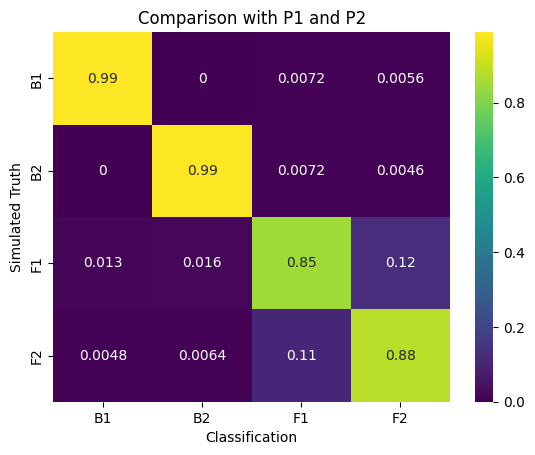

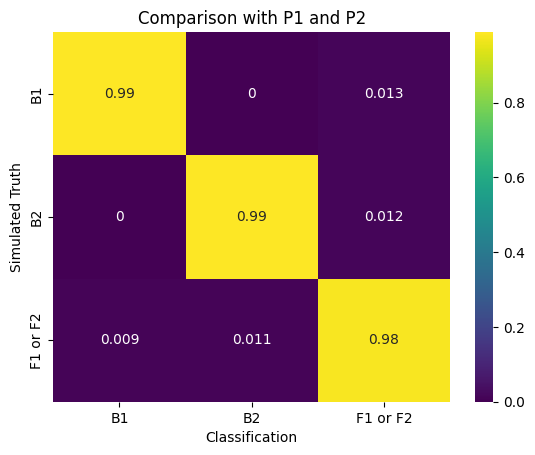

In [14]:
#plot multi-way classification accuracy

max_likelihood_classification = defaultdict(list)
for G in ['B1','B2', 'F1', 'F2']:
    for x in sim_indiv[G]:
        max_likelihood_classification[G].append(max(x.complete_likelihoods, key=x.complete_likelihoods.get))

plt.figure()
classification_matrix = []
for G in ['B1','B2', 'F1', 'F2']:
    counts = Counter(max_likelihood_classification[G])
    classification_matrix.append([counts[G] for G in ['B1', 'B2', 'F1', 'F2']])
classification_matrix = np.asarray(classification_matrix) / 5000

sns.heatmap(classification_matrix, annot = classification_matrix, cmap = 'viridis',
           xticklabels = ['B1','B2', 'F1', 'F2'], yticklabels = ['B1','B2', 'F1', 'F2'])
plt.ylabel('Simulated Truth')
plt.xlabel('Classification')

plt.title('Comparison with P1 and P2')

plt.figure()
classification_matrix = []
for G in ['B1','B2']:
    counts = Counter(max_likelihood_classification[G])
    classification_matrix.append([counts['B1'], counts['B2'], counts['F1'] + counts['F2']])

not_backcross_row = np.zeros(3)
for G in ['F1', 'F2']:
    counts = Counter(max_likelihood_classification[G])
    not_backcross_row += np.asarray([counts['B1'], counts['B2'], counts['F1'] + counts['F2']]) / 2.
classification_matrix.append(not_backcross_row)
classification_matrix = np.asarray(classification_matrix) / 5000

sns.heatmap(classification_matrix, annot = classification_matrix, cmap = 'viridis',
           xticklabels = ['B1','B2', 'F1 or F2'], yticklabels = ['B1','B2', 'F1 or F2'])
plt.ylabel('Simulated Truth')
plt.xlabel('Classification')

plt.title('Comparison with P1 and P2')


In [15]:
class tri_Sim:
    #the three comparisons
    G_model_dict = {'F1.F1': ('P1.F11', 'P1.F12', 'F11.F12'),
                    'F1.F2': ('P1.F11', 'P1.F21', 'F11.F21'),
                    'F2.F2': ('P1.F21', 'P1.F21', 'F21.F22')}
    
    
    def __init__(self, truth, r_total_dict, 
                 max_ibd_segment_dict, 
                 n_segment_count_dict, p1_s1_flag = 1, p1_s2_flag = 1, s1_s2_flag = 1):
        self.truth = truth
        self.r_total_dict = r_total_dict #contain 3 keys, s1.p1 s2.p1, s1.s2
        self.max_ibd_segment_dict = max_ibd_segment_dict
        self.n_segment_count_dict = n_segment_count_dict
        self.p1_s1_flag = p1_s1_flag
        self.p1_s2_flag = p1_s2_flag
        self.s1_s2_flag = s1_s2_flag
        
        self.calc_all_likelihoods()
        
    def calc_logp_rtotal(self, G_model, data):
        r_total_beta_params = pdfs['r_beta'][G_model]
        P_rtotal = scipy.stats.beta.logpdf(data, *r_total_beta_params)
        return P_rtotal

    def calc_logp_max_ibd_segment(self, G_model, data, chrom):
        #data set to self.max_ibd_segment[p][idx] data
        return np.log(evaluate_max_segment_piecewise_pdf(data, G_model, chrom, pdfs['p_max_segment']))

    def calc_logp_p_seg_count(self, G_model, data, chrom):
        n_segments = data
        if n_segments in pdfs['segment_count'][G_model][str(chrom)].keys():
            P_seg_count = np.log(pdfs['segment_count'][G_model][str(chrom)][n_segments])
        else:
            P_seg_count = np.log(pdfs['segment_count'][G_model][str(chrom)]['misc'])
        return P_seg_count

    def likelihood(self, G_model, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        #G_model is the relationship to test (F1.F1, F1.F2, F2.F2)
        logL = 0
        P_rtotal = 0
        P_ibdmax = 0
        P_seg_count = 0

        G_p1_s1, G_p1_s2, G_s1_s2 = tri_Sim.G_model_dict[G_model] 

        #p1_s1
        P_rtotal += (self.p1_s1_flag * self.calc_logp_rtotal(G_p1_s1, self.r_total_dict['P1.s1']))
        #p1_s2
        P_rtotal += (self.p1_s2_flag * self.calc_logp_rtotal(G_p1_s2, self.r_total_dict['P1.s2']))
        #s1_s2
        P_rtotal += (self.s1_s2_flag * self.calc_logp_rtotal(G_s1_s2, self.r_total_dict['s1.s2']))

        for chrom in range(1,15):
            chrom_idx = chrom - 1
            P_ibdmax += (self.p1_s1_flag * self.calc_logp_max_ibd_segment(G_p1_s1, self.max_ibd_segment_dict['P1.s1'][chrom_idx], chrom))
            P_ibdmax += (self.p1_s2_flag * self.calc_logp_max_ibd_segment(G_p1_s2, self.max_ibd_segment_dict['P1.s2'][chrom_idx], chrom))
            P_ibdmax += (self.s1_s2_flag * self.calc_logp_max_ibd_segment(G_s1_s2, self.max_ibd_segment_dict['s1.s2'][chrom_idx], chrom))

            P_seg_count += (self.p1_s1_flag * self.calc_logp_p_seg_count(G_p1_s1, self.n_segment_count_dict['P1.s1'][chrom_idx],chrom))
            P_seg_count += (self.p1_s2_flag * self.calc_logp_p_seg_count(G_p1_s2, self.n_segment_count_dict['P1.s2'][chrom_idx],chrom))
            P_seg_count += (self.s1_s2_flag * self.calc_logp_p_seg_count(G_s1_s2, self.n_segment_count_dict['s1.s2'][chrom_idx],chrom))
        logL = P_rtotal * r_flag +  P_ibdmax * ibdmax_flag + P_seg_count * count_flag

        return logL

    def calc_all_likelihoods(self, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        self.complete_likelihoods = {}
        self.r_likelihoods = {}
        for classification in tri_Sim.G_model_dict:
            self.complete_likelihoods[classification] = self.likelihood(classification, r_flag, ibdmax_flag, count_flag)
        self.max_likelihood = max(self.complete_likelihoods, key=self.complete_likelihoods.get)

            
n_sims = len(raw_sim_data['fs']['ibd_segment_numbers']['P1.B11']['1'])
tri_sim_indiv = defaultdict(list)
pairwise_sim_indiv = defaultdict(list)
sim_type = 'fs'

s1_s2_dict = {'F1.F1': ('F11', 'F12'),
             'F1.F2' : ('F11', 'F21'),
             'F2.F2' : ('F21', 'F22'),
             'B1.F1' : ('B11', 'F12'),
             'B1.F2' : ('B11', 'F21'),
             'B2.F1' : ('B21', 'F11'),
              'B2.F2': ('B21', 'F21'),
              'B1.B2': ('B11', 'B21'),
             }
for classification in ['F1.F1', 'F1.F2', 'F2.F2']:  #root classification
    print(classification)
    for sim_idx in range(n_sims):
        if sim_idx % 500 == 0:
            print(sim_idx)
        max_segment_dict = {}
        count_dict = {}
        r_total_dict = {}
        
        s1, s2 = s1_s2_dict[classification]
        
        G_p1_s1 = 'P1.' + s1
        G_p1_s2 = 'P1.' + s2
        G_s1_s2 = s1 + '.' + s2
        
        #instantiation of P1_s1 data
        max_segment_dict['P1.s1'] = [raw_sim_data[sim_type]['p_ibd_max'][G_p1_s1][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['P1.s1'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_p1_s1][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['P1.s1'] = raw_sim_data[sim_type]['r_totals'][G_p1_s1][sim_idx]
        
        #instantiation of P1_s2 data
        max_segment_dict['P1.s2'] = [raw_sim_data[sim_type]['p_ibd_max'][G_p1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['P1.s2'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_p1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['P1.s2'] = raw_sim_data[sim_type]['r_totals'][G_p1_s2][sim_idx]
        
        #instantiation of s1_s2 data
        max_segment_dict['s1.s2'] = [raw_sim_data[sim_type]['p_ibd_max'][G_s1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['s1.s2'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_s1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['s1.s2'] = raw_sim_data[sim_type]['r_totals'][G_s1_s2][sim_idx]

        S = tri_Sim(classification, r_total_dict, \
                                      max_segment_dict, count_dict)
        
        S_s1_s2 = tri_Sim(classification, r_total_dict, \
                                      max_segment_dict, count_dict, 0,0,1)
        tri_sim_indiv[classification].append(S)
        pairwise_sim_indiv[classification].append(S_s1_s2)
    
        
        
        

F1.F1
0
500
1000
1500
2000
2500
3000
3500
4000
4500
F1.F2
0
500
1000
1500
2000
2500
3000
3500
4000
4500
F2.F2
0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'Triangulation Strategy')

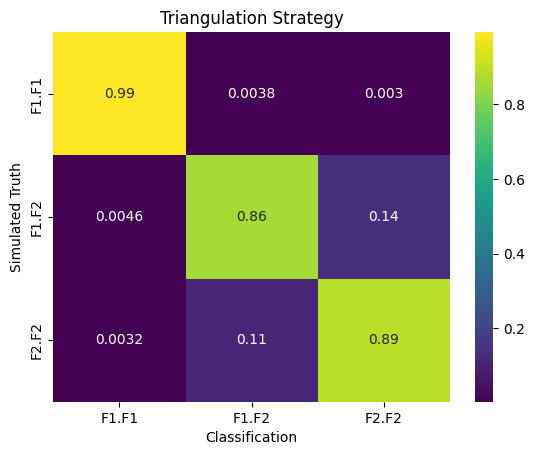

In [16]:
triangle_classification_matrix = []
for key in ['F1.F1', 'F1.F2', 'F2.F2']:
    max_likelihood_counts = Counter([x.max_likelihood for x in tri_sim_indiv[key]])
    triangle_classification_matrix.append([max_likelihood_counts[k] for k in ['F1.F1', 'F1.F2', 'F2.F2']])
triangle_classification_matrix = np.asarray(triangle_classification_matrix) / 5000.

pairwise_classification_matrix = []
for key in ['F1.F1', 'F1.F2', 'F2.F2']:
    max_likelihood_counts = Counter([x.max_likelihood for x in pairwise_sim_indiv[key]])
    pairwise_classification_matrix.append([max_likelihood_counts[k] for k in ['F1.F1', 'F1.F2', 'F2.F2']])
pairwise_classification_matrix = np.asarray(pairwise_classification_matrix) / 5000.

sns.heatmap(triangle_classification_matrix, annot = triangle_classification_matrix, cmap = 'viridis',
           xticklabels = ['F1.F1', 'F1.F2', 'F2.F2'], yticklabels = ['F1.F1', 'F1.F2', 'F2.F2'])
plt.xlabel('Classification')
plt.ylabel('Simulated Truth')
plt.title('Triangulation Strategy')

#plt.savefig('f1_f2_pairwise_categorization.svg')

Text(0.5, 1.0, 'Pairwise Comparison')

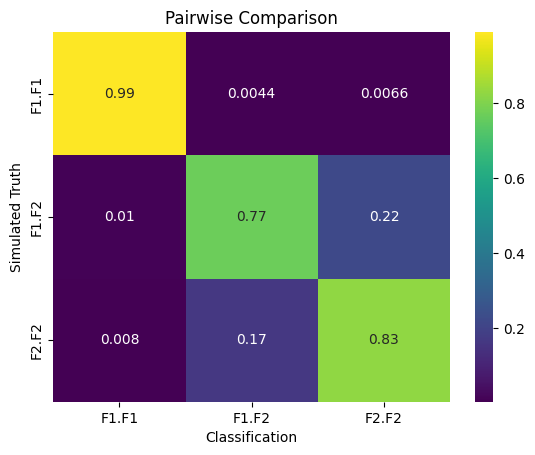

In [17]:
sns.heatmap(pairwise_classification_matrix, annot = pairwise_classification_matrix, cmap = 'viridis',
           xticklabels = ['F1.F1', 'F1.F2', 'F2.F2'], yticklabels = ['F1.F1', 'F1.F2', 'F2.F2'])
plt.xlabel('Classification')
plt.ylabel('Simulated Truth')
plt.title('Pairwise Comparison')

In [18]:
def calc_logp_rtotal(G_model, data):
        r_total_beta_params = pdfs['r_beta'][G_model]
        P_rtotal = scipy.stats.beta.logpdf(data, *r_total_beta_params)
        return P_rtotal

def calc_logp_max_ibd_segment(G_model, data, chrom):
    #data set to self.max_ibd_segment[p][idx] data
    return np.log(evaluate_max_segment_piecewise_pdf(data, G_model, chrom, pdfs['p_max_segment']))

def calc_logp_p_seg_count(G_model, data, chrom):
    n_segments = data
    if n_segments in pdfs['segment_count'][G_model][str(chrom)].keys():
        P_seg_count = np.log(pdfs['segment_count'][G_model][str(chrom)][n_segments])
    else:
        P_seg_count = np.log(pdfs['segment_count'][G_model][str(chrom)]['misc'])
    return P_seg_count



genealogy_classes = ['B1', 'B2', 'F1', 'F2']
    
genealogy_keyswaps = {}
for G in genealogy_classes:
    genealogy_keyswaps[G + ':' + G] = ('P1.' + G +'1', #p1_s1
                                       'P2.' + G +'1', #p2_s1
                                       'P1.' + G +'1', #p1_s2
                                       'P2.' + G +'1', #p2_s2
                                       G+ '1.' + G + '2') #s1_s2

for x in itertools.permutations(genealogy_classes,2):
    s1,s2 = x
    combo =s1+ '1.' + s2 + '2'
    if combo in ['B21.B12','B11.F12','B21.F12', 'F21.B12', 'F21.B22', 'F21.F12']:
        genealogy_keyswaps[s1 + ':' + s2] = ('P1.' + s1 +'1',
                                           'P2.' + s1 +'1',
                                             'P1.' + s2 +'1',
                                           'P2.' + s2 +'1',
                                           s2+ '1.' + s1 + '2') 
    else:
        genealogy_keyswaps[s1 + ':' + s2] = ('P1.' + s1 +'1',
                                           'P2.' + s1 +'1',
                                             'P1.' + s2 +'1',
                                           'P2.' + s2 +'1',
                                           s1+ '1.' + s2 + '2')

In [ ]:

class multi_Sim:
    #the three comparisons
    G_model_dict = genealogy_keyswaps
    
    def __init__(self, truth, r_total_dict, 
                 max_ibd_segment_dict, 
                 n_segment_count_dict, p1_s1_flag = 1, p1_s2_flag = 1, s1_s2_flag = 1):
        self.truth = truth
        self.r_total_dict = r_total_dict #contain 3 keys, s1.p1 s2.p1, s1.s2
        self.max_ibd_segment_dict = max_ibd_segment_dict
        self.n_segment_count_dict = n_segment_count_dict
        self.p1_s1_flag = p1_s1_flag
        self.p1_s2_flag = p1_s2_flag
        self.s1_s2_flag = s1_s2_flag
        
        self.calc_all_likelihoods()
        
    def calc_logp_rtotal(self, G_model, data):
        r_total_beta_params = pdfs['r_beta'][G_model]
        P_rtotal = scipy.stats.beta.logpdf(data, *r_total_beta_params)
        return P_rtotal

    def calc_logp_max_ibd_segment(self, G_model, data, chrom):
        #data set to self.max_ibd_segment[p][idx] data
        return np.log(evaluate_max_segment_piecewise_pdf(data, G_model, chrom, pdfs['p_max_segment']))

    def calc_logp_p_seg_count(self, G_model, data, chrom):
        n_segments = data
        if n_segments in pdfs['segment_count'][G_model][str(chrom)].keys():
            P_seg_count = np.log(pdfs['segment_count'][G_model][str(chrom)][n_segments])
        else:
            P_seg_count = np.log(pdfs['segment_count'][G_model][str(chrom)]['misc'])
        return P_seg_count

    def likelihood(self, G_model, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        #G_model is the relationship to test (F1.F1, F1.F2, F2.F2)
        logL = 0
        P_rtotal = 0
        P_ibdmax = 0
        P_seg_count = 0
    
        G_p1_s1, G_p2_s1, G_p1_s2, G_p2_s2, G_s1_s2 = multi_Sim.G_model_dict[G_model] 

        P_rtotal += (self.calc_logp_rtotal(G_p1_s1, self.r_total_dict['P1.s1']))
        P_rtotal += (self.calc_logp_rtotal(G_p2_s1, self.r_total_dict['P2.s1']))
        P_rtotal += (self.calc_logp_rtotal(G_p1_s2, self.r_total_dict['P1.s1']))
        P_rtotal += (self.calc_logp_rtotal(G_p2_s2, self.r_total_dict['P2.s2']))
        P_rtotal += (self.calc_logp_rtotal(G_s1_s2, self.r_total_dict['s1.s2']))

        for chrom in range(1,15):
            chrom_idx = chrom - 1
            P_ibdmax += (self.calc_logp_max_ibd_segment(G_p1_s1, self.max_ibd_segment_dict['P1.s1'][chrom_idx], chrom))
            P_ibdmax += (self.calc_logp_max_ibd_segment(G_p1_s2, self.max_ibd_segment_dict['P1.s2'][chrom_idx], chrom))
            P_ibdmax += (self.calc_logp_max_ibd_segment(G_p2_s1, self.max_ibd_segment_dict['P2.s1'][chrom_idx], chrom))
            P_ibdmax += (self.calc_logp_max_ibd_segment(G_p2_s2, self.max_ibd_segment_dict['P2.s2'][chrom_idx], chrom))
            P_ibdmax += (self.calc_logp_max_ibd_segment(G_s1_s2, self.max_ibd_segment_dict['s1.s2'][chrom_idx], chrom))

            P_seg_count += (self.calc_logp_p_seg_count(G_p1_s1, self.n_segment_count_dict['P1.s1'][chrom_idx],chrom))
            P_seg_count += (self.calc_logp_p_seg_count(G_p1_s2, self.n_segment_count_dict['P1.s2'][chrom_idx],chrom))
            P_seg_count += (self.calc_logp_p_seg_count(G_p2_s1, self.n_segment_count_dict['P2.s1'][chrom_idx],chrom))
            P_seg_count += (self.calc_logp_p_seg_count(G_p2_s2, self.n_segment_count_dict['P2.s2'][chrom_idx],chrom))
            P_seg_count += (self.calc_logp_p_seg_count(G_s1_s2, self.n_segment_count_dict['s1.s2'][chrom_idx],chrom))
        logL = P_rtotal * r_flag +  P_ibdmax * ibdmax_flag + P_seg_count * count_flag

        return logL

    def calc_all_likelihoods(self, r_flag = 1, ibdmax_flag = 1, count_flag = 1):
        self.complete_likelihoods = {}
        self.r_likelihoods = {}
        for classification in multi_Sim.G_model_dict:
            self.complete_likelihoods[classification] = self.likelihood(classification, r_flag, ibdmax_flag, count_flag)
        self.max_likelihood = max(self.complete_likelihoods, key=self.complete_likelihoods.get)

            
n_sims = len(raw_sim_data['fs']['ibd_segment_numbers']['P1.B11']['1'])
multi_Sim_indiv = defaultdict(list)
sim_type = 'fs'


s1_s2_dict = {}
for key in relationships:
    s1_s2_dict[key] = (key.split(':')[0], key.split(':')[1])

for classification in multi_Sim.G_model_dict:
    print(classification)
    s1, s2 = classification.split(':')
    G_p1_s1, G_p2_s1, G_p1_s2, G_p2_s2, G_s1_s2 = multi_Sim.G_model_dict[classification] 
    if G_s1_s2 in ['B21.B12','B11.F12','B21.F11', 'F21.B12', 'F21.B22', 'F21.F12']:
        G_s1_s2 = s2 + '.' + s1
    print(s1,s2, G_p1_s1,G_p2_s1,G_p1_s2,G_p2_s2,G_s1_s2)
        
    
    for sim_idx in range(n_sims):
        if sim_idx % 500 == 0:
            print(sim_idx)
        max_segment_dict = {}
        count_dict = {}
        r_total_dict = {}
        
        
        #instantiation of P1_s1 data
        max_segment_dict['P1.s1'] = [raw_sim_data[sim_type]['p_ibd_max'][G_p1_s1][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['P1.s1'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_p1_s1][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['P1.s1'] = raw_sim_data[sim_type]['r_totals'][G_p1_s1][sim_idx]
        
        #instantiation of P2_s1 data
        max_segment_dict['P2.s1'] = [raw_sim_data[sim_type]['p_ibd_max'][G_p2_s1][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['P2.s1'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_p2_s1][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['P2.s1'] = raw_sim_data[sim_type]['r_totals'][G_p2_s1][sim_idx]
        
        #instantiation of P1_s2 data
        max_segment_dict['P1.s2'] = [raw_sim_data[sim_type]['p_ibd_max'][G_p1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['P1.s2'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_p1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['P1.s2'] = raw_sim_data[sim_type]['r_totals'][G_p1_s2][sim_idx]
        
        #instantiation of P2_s2 data
        max_segment_dict['P2.s2'] = [raw_sim_data[sim_type]['p_ibd_max'][G_p2_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['P2.s2'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_p2_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['P2.s2'] = raw_sim_data[sim_type]['r_totals'][G_p2_s2][sim_idx]
        
        #instantiation of s1_s2 data
        max_segment_dict['s1.s2'] = [raw_sim_data[sim_type]['p_ibd_max'][G_s1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        count_dict['s1.s2'] = [raw_sim_data[sim_type]['ibd_segment_numbers'][G_s1_s2][str(chrom)][sim_idx] for chrom in range(1,15)]
        r_total_dict['s1.s2'] = raw_sim_data[sim_type]['r_totals'][G_s1_s2][sim_idx]

        S = multi_Sim(classification, r_total_dict, \
                                      max_segment_dict, count_dict)

        multi_Sim_indiv[classification].append(S)
    
        
        
        

B1:B1
B1 B1 P1.B11 P2.B11 P1.B11 P2.B11 B11.B12
0
500
1000
1500
2000
2500
3000
3500
4000
4500
B2:B2
B2 B2 P1.B21 P2.B21 P1.B21 P2.B21 B21.B22
0
500
1000
1500
2000
2500
3000
3500
4000
4500
F1:F1
F1 F1 P1.F11 P2.F11 P1.F11 P2.F11 F11.F12
0
500
1000
1500
2000
2500
3000
3500
4000
4500
F2:F2
F2 F2 P1.F21 P2.F21 P1.F21 P2.F21 F21.F22
0
500
1000
1500


In [ ]:
multi_M = []
sorted_keys = sorted(list(multi_Sim.G_model_dict.keys()), reverse = True)
for key in sorted_keys:
    counts = Counter([S.max_likelihood for S in multi_Sim_indiv[key]])
    multi_M.append([round(counts[k]/5000,2) if k in counts else 0 for k in sorted_keys])
multi_M = np.asarray(multi_M)

In [ ]:
condensed_classification = defaultdict(lambda: defaultdict(lambda: 0))
for key in S.G_model_dict.keys():
    split_key = key.split(':')
    s1_status = split_key[0]
    s2_status = split_key[1]
    
    max_likelihood_counts = Counter([S.max_likelihood for S in multi_Sim_indiv[key]])
    for inferred_classification in max_likelihood_counts:
        inferred_s1, inferred_s2 = inferred_classification.split(':')
        condensed_classification[s1_status][inferred_s1] += max_likelihood_counts[inferred_classification]
        condensed_classification[s2_status][inferred_s2] += max_likelihood_counts[inferred_classification]
        
for k1 in condensed_classification:
    for k2 in condensed_classification[k1]:
        condensed_classification[k1][k2] = condensed_classification[k1][k2] / 40000

In [ ]:

inbred_c_dict= {'F1': 'red', 'F2': 'purple', 'B1': 'orange', 'B2': 'gold'}
plt.figure(figsize=(6,6))
g_idx = 1
for classification in ['F1', 'F2', 'B1', 'B2']:
    plt.subplot(2,2,g_idx)
    p = condensed_classification[classification][classification]
    yerr_top = 1.96 * np.sqrt(p * (1-p) / 5000)#[[0], [1.96 * np.sqrt(p * (1-p) / 5000)]]
    baseline = 0
    
    plt.bar(0, p, width=0.3, color = inbred_c_dict[classification],
           yerr = yerr_top, capsize = 5)
    plt.errorbar(0.4, 1-p, yerr = yerr_top, capsize = 5, color = 'black')
    
    for inferred in sorted(condensed_classification[classification], 
                           key= lambda k :condensed_classification[classification][k],
                          reverse = True):    
        if inferred != classification:
            height = condensed_classification[classification][inferred]
            plt.bar(0.4, height, bottom = baseline, width = 0.3, color = inbred_c_dict[inferred])
            baseline += height
    if g_idx == 4:
        handles = [mpatches.Patch(color=inbred_c_dict[label], label=label) for label in inbred_c_dict]
        plt.legend(handles=handles)
    
    plt.xticks([0, 0.4], ['{x}|{x}'.format(x = classification), 'Misclassified'], fontsize = 14)
    plt.title('BCDE'[g_idx-1], fontsize = 18, loc = 'left')
    plt.ylabel('Classification Rate', fontsize = 14)
    g_idx += 1
    plt.ylim(0,1)
plt.tight_layout()

#plt.savefig('/Users/weswong/Wirth Lab Dropbox/wes wong/MalKinID/Figures/inbred_f1_f2_classification.svg')